<a href="https://colab.research.google.com/github/Gitaalekh6763/string_diagram_QNLP/blob/main/QNLP_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**QNLP ASSIGNMENT:-**

The following code and explanation offer a comprehensive overview of Quantum Natural Language Processing (QNLP) using the lambeq library, PyTorch, and PennyLane. This QNLP pipeline involves several essential steps, starting with data input and preprocessing. Sentences are transformed into string diagrams, simplified, and then converted into quantum circuits using an IQPAnsatz. A hybrid QNLP model, named XORSentenceModel, combines these circuits with a neural network to determine whether pairs of sentences pertain to the same or different topics.

The QNLP model's structure is shaped by the grammatical structure of the input sentence, and lambeq initiates this process by employing a parser. Lambeq's current version incorporates Bobcat, an advanced parser trained using neural networks, while also accommodating various other parsers.

Following the parsing phase, lambeq generates a syntax tree for the sentence, which is then transformed into an abstract representation called a "string diagram." This representation encapsulates the word relationships as defined by a chosen compositional model. Importantly, this step is conducted independently of lower-level implementation details.

String diagrams, which can be formally described using category theory, are subject to further simplification through the application of rewriting rules. These rules facilitate the removal of specific word interactions that may be deemed redundant for the given task or that enhance the feasibility of implementation on a quantum processing unit.

Ultimately, lambeq proceeds to convert the refined string diagram into a tangible quantum circuit. This conversion relies on a specific parameterization approach and concrete choices of ansätze. The resulting quantum circuit is then ready for use in training purposes.

To illustrate this process, we will train a hybrid model named PennyLaneModel. This model's objective is to ascertain whether a given pair of sentences pertains to different topics. To achieve this, we will employ an IQPAnsatz to translate string diagrams into quantum circuits. Notably, when these circuits are provided to the model, they are automatically converted into PennyLane circuits.

In [27]:
 !pip install lambeq

In [28]:
from lambeq import SpacyTokeniser

tokeniser = SpacyTokeniser()
sentence = "This sentence isn't worth £100 (or is it?)."
tokens = tokeniser.tokenise_sentence(sentence)
tokens

['This',
 'sentence',
 'is',
 "n't",
 'worth',
 '£',
 '100',
 '(',
 'or',
 'is',
 'it',
 '?',
 ')',
 '.']

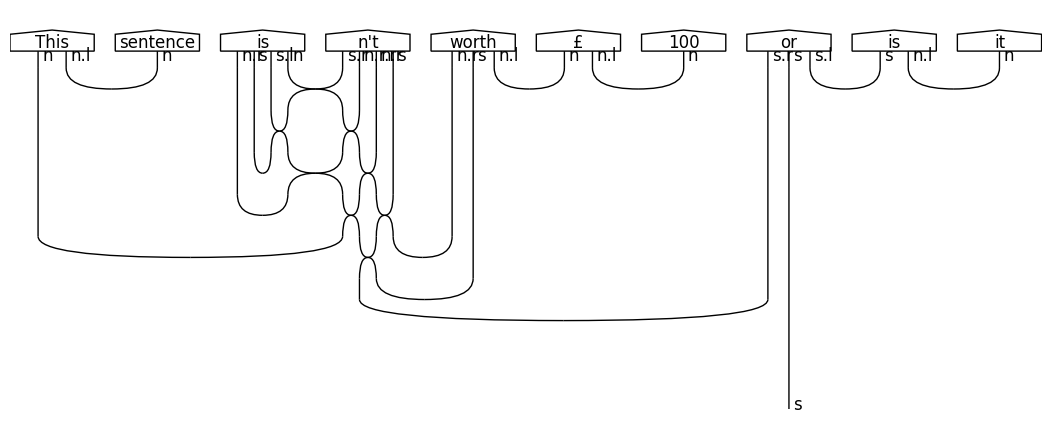

In [29]:
from lambeq import BobcatParser, pregroups

parser = BobcatParser(verbose='suppress')
diagram = parser.sentence2diagram(tokens, tokenised=True)

pregroups.draw(diagram, figsize=(23,4), fontsize=12)

In [30]:
sentences = ["This is a sentence.", "This is (another) sentence!"]

tok_sentences = tokeniser.tokenise_sentences(sentences)
tok_sentences

[['This', 'is', 'a', 'sentence', '.'],
 ['This', 'is', '(', 'another', ')', 'sentence', '!']]

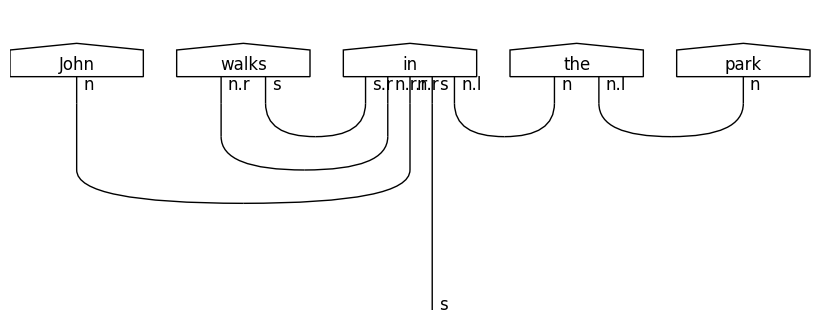

In [31]:
from lambeq import BobcatParser, pregroups

sentence = 'John walks in the park'

# Parse the sentence and convert it into a string diagram
parser = BobcatParser(verbose='suppress')
diagram = parser.sentence2diagram(sentence)

pregroups.draw(diagram, figsize=(14,3), fontsize=12)

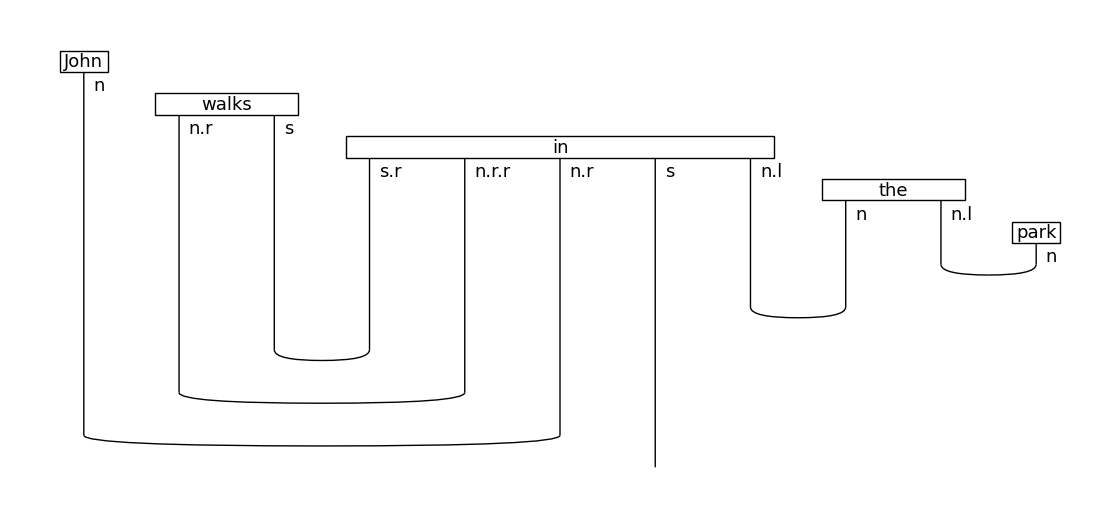

In [32]:

# Parse the sentence
parser = BobcatParser(verbose='suppress')
diagram = parser.sentence2diagram("John walks in the park")

diagram.draw(figsize=(11,5), fontsize=13)

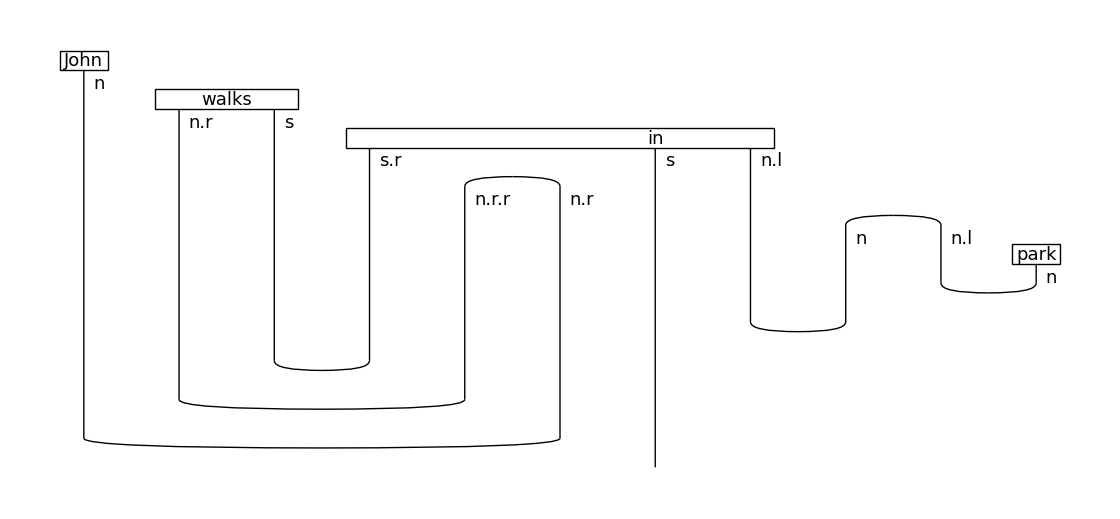

In [33]:
from lambeq import Rewriter

# Apply rewrite rule for prepositional phrases

rewriter = Rewriter(['prepositional_phrase', 'determiner'])
rewritten_diagram = rewriter(diagram)

rewritten_diagram.draw(figsize=(11,5), fontsize=13)

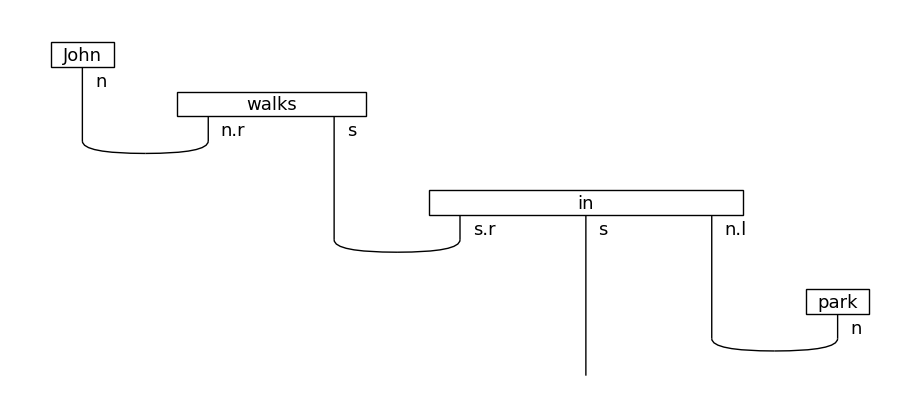

In [34]:
normalised_diagram = rewritten_diagram.normal_form()
normalised_diagram.draw(figsize=(9,4), fontsize=13)

In [35]:
sentence = 'John walks in the park'

# Get a string diagram
parser = BobcatParser(verbose='text')
diagram = parser.sentence2diagram(sentence)

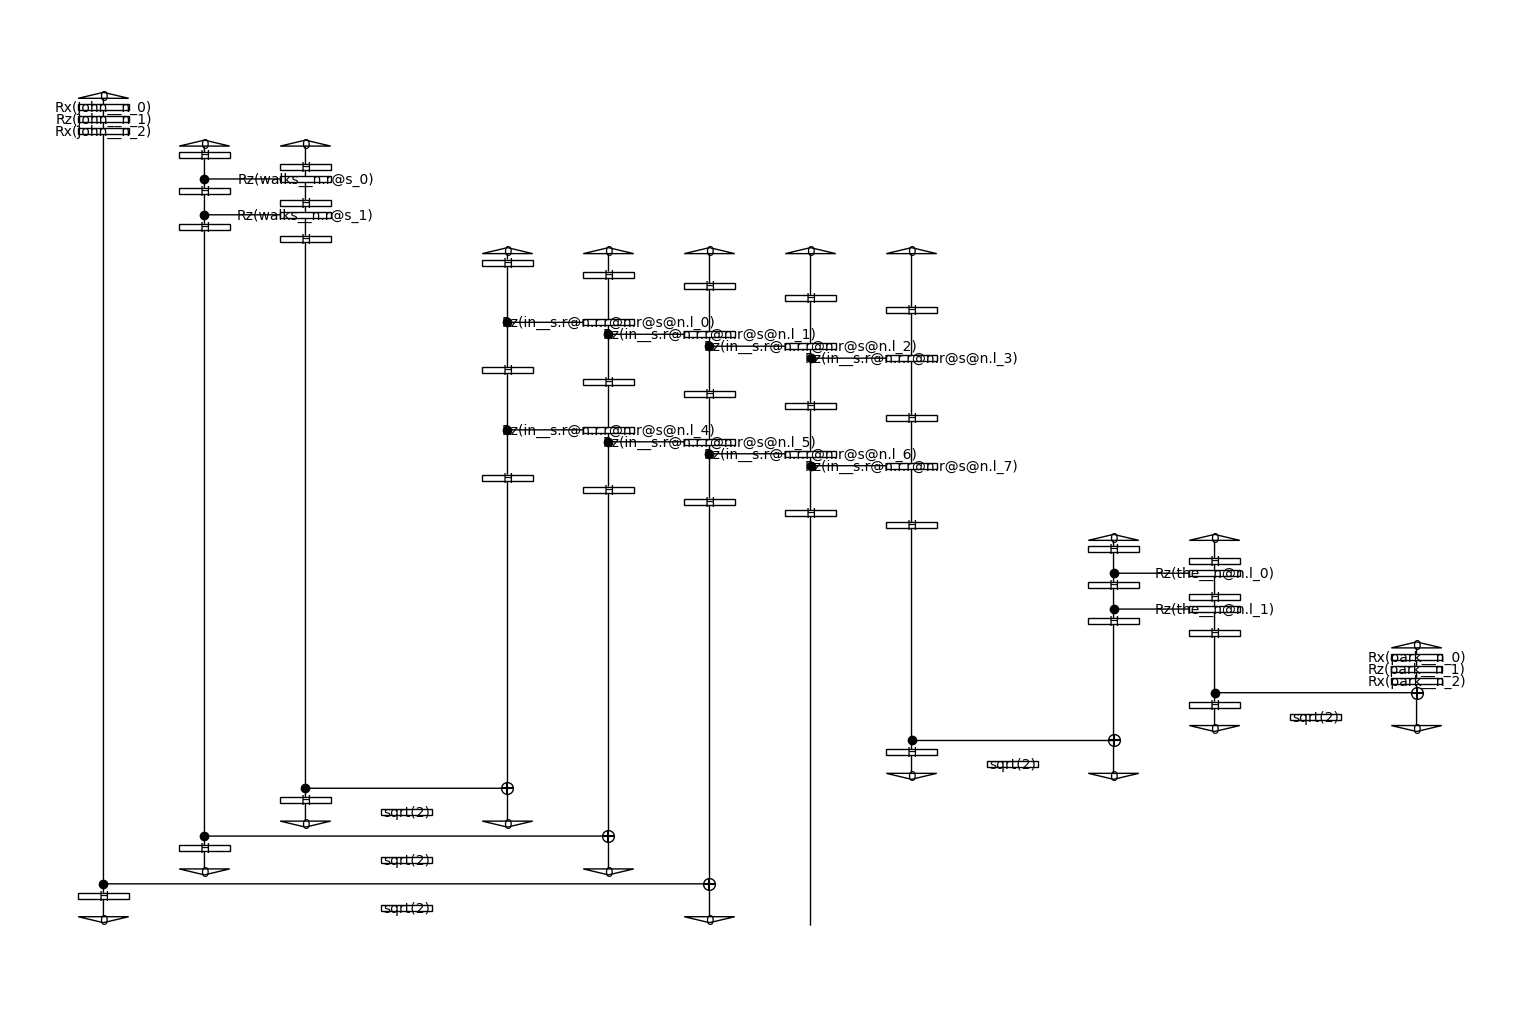

In [36]:
from lambeq import AtomicType, IQPAnsatz

# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Convert string diagram to quantum circuit
ansatz = IQPAnsatz({N: 1, S: 1}, n_layers=2)
discopy_circuit = ansatz(diagram)
discopy_circuit.draw(figsize=(15,10))

In [37]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = discopy_circuit.to_tk()

render_circuit_jupyter(tket_circuit)

In [38]:
!pip install pytket-qiskit

In [39]:
from pytket.extensions.qiskit import tk_to_qiskit

qiskit_circuit = tk_to_qiskit(tket_circuit)

In [40]:
import torch

BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

In [41]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            line = line.split(',')
            labels.append(int(line[2]))
            sentences.append((line[0], line[1]))
    return labels, sentences

train_labels, train_data = read_data('/content/mc_pair_dev_data.csv')
dev_labels, dev_data = read_data('/content/mc_pair_dev_data.csv')
test_labels, test_data = read_data('/content/mc_pair_test_data.csv')

print(list(zip(train_data[:5], train_labels[:5])))

[(('man bakes sauce .', 'skillful woman runs software .'), 0), (('man runs program .', 'skillful person prepares sauce .'), 0), (('man prepares tasty sauce .', 'man debugs application .'), 0), (('woman prepares software .', 'woman cooks sauce .'), 0), (('skillful woman prepares application .', 'woman prepares useful application .'), 1)]


In [42]:
train_data_l, train_data_r = zip(*train_data)
train_data_unpaired = list(train_data_l) + list(train_data_r)
dev_data_l, dev_data_r = zip(*dev_data)
dev_data_unpaired = list(dev_data_l) + list(dev_data_r)
test_data_l, test_data_r = zip(*test_data)
test_data_unpaired = list(test_data_l) + list(test_data_r)

In [43]:
reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data_unpaired)
raw_dev_diagrams = reader.sentences2diagrams(dev_data_unpaired)
raw_test_diagrams = reader.sentences2diagrams(test_data_unpaired)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [44]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

In [45]:
!pip install pennylane

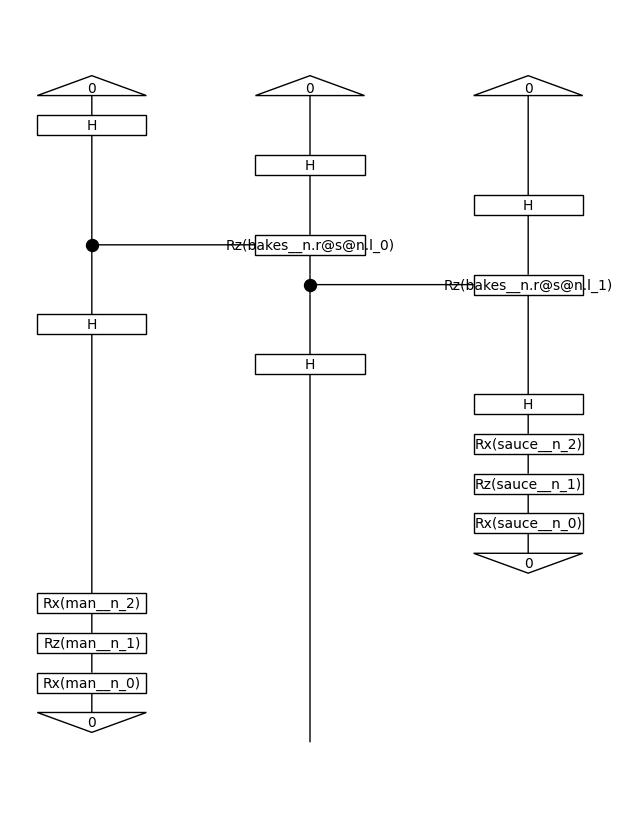

In [46]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

In [47]:
from torch import nn
from lambeq import PennyLaneModel

# inherit from PennyLaneModel to use the PennyLane circuit evaluation
class XORSentenceModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.xor_net = nn.Sequential(nn.Linear(4, 10),
                                     nn.ReLU(),
                                     nn.Linear(10, 1),
                                     nn.Sigmoid())

    def forward(self, diagram_pairs):
        first_d, second_d = zip(*diagram_pairs)
        # evaluate each circuit and concatenate the results
        evaluated_pairs = torch.cat((self.get_diagram_output(first_d),
                                     self.get_diagram_output(second_d)),
                                    dim=1)
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        # pass the concatenated results through a simple neural network
        return self.xor_net(evaluated_pairs)

In [48]:
def make_pair_data(diagrams):
    pair_diags = list(zip(diagrams[:len(diagrams)//2], diagrams[len(diagrams)//2:]))
    return pair_diags

train_pair_circuits = make_pair_data(train_circuits)
dev_pair_circuits = make_pair_data(dev_circuits)
test_pair_circuits = make_pair_data(test_circuits)

In [49]:
from lambeq import Dataset

all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

# initialise our model by passing in the diagrams, so that we have trainable parameters for each token
model = XORSentenceModel.from_diagrams(a + b, probabilities=True, normalize=True)
model.initialise_weights()
model = model.double()

# initialise datasets and optimizers as in PyTorch
train_pair_dataset = Dataset(train_pair_circuits,
                             train_labels,
                             batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [50]:
def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) ==
            torch.DoubleTensor(labels)).sum().item()/len(circs)

In [51]:
best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)
        # use BCELoss as our outputs are probabilities, and labels are binary
        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.DoubleTensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    # evaluate on dev set every 5 epochs
    # save the model if it's the best so far
    # stop training if the model hasn't improved for 10 epochs
    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_labels)

        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save('xor_model.lt')
        elif i - best['epoch'] >= 10:
            print('Early stopping')
            break

# load the best performing iteration of the model on the dev set
if best['acc'] > accuracy(dev_pair_circuits, dev_labels):
    model.load('xor_model.lt')
    model = model.double()

Epoch: 0
Train loss: 5.010928785482308
Dev acc: 0.495
Epoch: 5
Train loss: 4.934898373486496
Dev acc: 0.525
Epoch: 10
Train loss: 4.619362950052515
Dev acc: 0.67
Epoch: 15
Train loss: 4.937153242650283
Dev acc: 0.645
Epoch: 20
Train loss: 3.596640215859223
Dev acc: 0.75
Epoch: 25
Train loss: 2.643050981128954
Dev acc: 0.93
